## 1. <font color = red> Install and Import the Required Libraries

In [1]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

In [2]:
# Import all the required libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Read, Process PDF File

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [4]:
# Define PDF path
pdf_path = "/content/drive/My Drive/Colab Notebooks/Policy+Documents/Principal-Sample-Life-Insurance-Policy.pdf"

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [5]:
# Open the PDF file and print the text
with pdfplumber.open(pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

In [6]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [7]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

* Now that we have defined the function for extracting the text

In [8]:

# Initialize an empty list to store the extracted texts and document names
data = []

# Process the PDF file
print(f"...Processing {pdf_path}")

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(pdf_path)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])

# Append the extracted text and document name to the list
data.append(extracted_text_df)

# Print a message to indicate progress
print(f"Finished processing {pdf_path}")

# Print a message to indicate all PDFs have been processed
print("PDF have been processed.")

...Processing /content/drive/My Drive/Colab Notebooks/Policy+Documents/Principal-Sample-Life-Insurance-Policy.pdf
Finished processing /content/drive/My Drive/Colab Notebooks/Policy+Documents/Principal-Sample-Life-Insurance-Policy.pdf
PDF have been processed.


In [9]:
# print the text
data

[   Page No.                                          Page_Text
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
 1    Page 2                 This page left blank intentionally
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
 3    Page 4                 This page left blank intentionally
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...
 ..      ...                                                ...
 59  Page 60  I f a Dependent who was insured dies during th...
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...
 61  Page 62  A claimant may request an appeal of a claim de...
 62  Page 63                 This page left blank intentionally
 63  Page 64  Principal Life Insurance Company Des Moines, I...
 
 [64 rows x 2 columns]]

In [10]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [11]:
# print Page No. and Page_Text from the dataframe
insurance_pdfs_data

,Page No.,Page_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 2,This page left blank intentionally
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,Page 4,This page left blank intentionally
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...,...
59,Page 60,I f a Dependent who was insured dies during th...
60,Page 61,Section D - Claim Procedures Article 1 - Notic...
61,Page 62,A claimant may request an appeal of a claim de...
62,Page 63,This page left blank intentionally


In [12]:
# Store the metadata for each page in a separate column, now we can consider the Page_No is the metadata
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Page_No.': x['Page No.']}, axis=1)
insurance_pdfs_data

,Page No.,Page_Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'}
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'}
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'}
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'}
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'}
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'}
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'}
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'}
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'}


In [13]:
# Check one of the extracted page texts to ensure that the text has been correctly read
insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [14]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [15]:
# print the page length
insurance_pdfs_data['Text_Length']

,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [16]:
# print the dataframe
insurance_pdfs_data

,Page No.,Page_Text,Metadata,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'},30
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'},5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'},230
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'},5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'},110
...,...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'},285
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'},418
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'},322
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'},5


## 3. <font color = 'red'> Document Chunking </font>

We will generate embeddings for texts. But the document contains several pages and huge text, before generating the embeddings, we need to generate the chunks. Let's start with a basic chunking technique, and chunk the text with fixed size.

#### Chunking a single document by fixed size
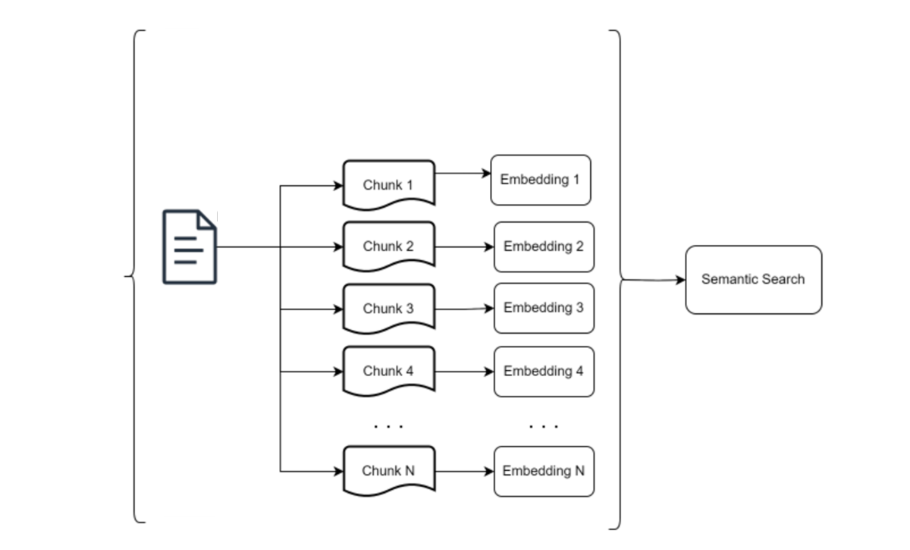

In [58]:
# Check the entire page's text
insurance_pdfs_data['Page_Text']

,Page_Text
0,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,This page left blank intentionally
2,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,This page left blank intentionally
4,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...
59,I f a Dependent who was insured dies during th...
60,Section D - Claim Procedures Article 1 - Notic...
61,A claimant may request an appeal of a claim de...
62,This page left blank intentionally


In [59]:
# Iterating over all page titles to create the final df with individual chunks
page_nos = insurance_pdfs_data["Page No."]
page_nos

,Page No.
0,Page 1
1,Page 2
2,Page 3
3,Page 4
4,Page 5
...,...
59,Page 60
60,Page 61
61,Page 62
62,Page 63


### 2.1 <font color = 'red'> Fixed-Size Chunking </font>

In fixed-size chunking, the document is split into fixed-size windows with each window representing a separate document chunk.

In [60]:
# Function to split text into fixed-size chunks
def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks## 3. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline

In [61]:
def process_page(page_no):
    page = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Page_Text.values[0]
    metadata = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Metadata.values[0]

    if page is not None:
        # setting chunk size as 500
        chunk_size = 500
        text_chunks = split_text_into_chunks(page, chunk_size)

        # Creating a DataFrame to store the chunks, page title and page metadata
        data = {'Title': [], 'Chunk Text': [], 'Metadata': []}

        for index, chunk in enumerate(text_chunks):
            data['Title'].append(page_no)
            data['Chunk Text'].append(chunk)
            # adding chunk no as part of metadata
            metadata['Chunk_No.'] = index
            data['Metadata'].append(metadata)

        return pd.DataFrame(data)

In [62]:
# creating a dataframe after calling process
all_dfs = []
for page_no in page_nos:
    df = process_page(page_no)
    if df is not None:
        all_dfs.append(df)

fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df

,Title,Chunk Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}"
1,Page 2,This page left blank intentionally,"{'Page_No.': 'Page 2', 'Chunk_No.': 0}"
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
3,Page 3,arrange for third party service providers (i.e...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
4,Page 3,the provision of such goods and/or services no...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
...,...,...,...
226,Page 62,"requested additional information, The Principa...","{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
227,Page 62,may have the Member or Dependent whose loss is...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
228,Page 62,proof of loss has been filed and before the ap...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
229,Page 63,This page left blank intentionally,"{'Page_No.': 'Page 63', 'Chunk_No.': 0}"


## 4. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline
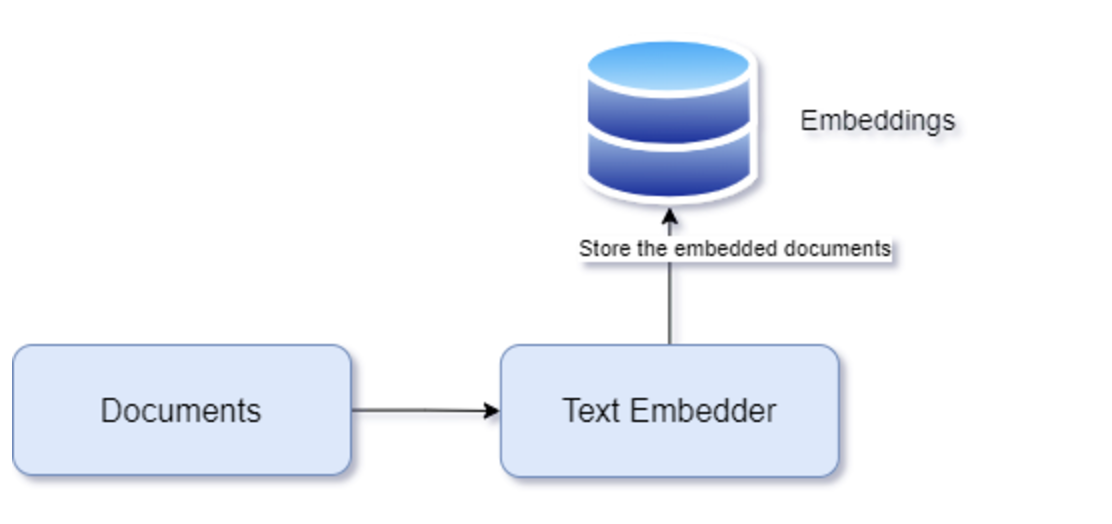

In [63]:
# Install the sentence transformers library
!pip install -q -u sentence-transformers


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [64]:
from sentence_transformers import SentenceTransformer, util

In [65]:
# Import the SentenceTransformer library
from sentence_transformers import SentenceTransformer

In [66]:
# Load the embedding model
model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [67]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=False)
    return embeddings

In [68]:
# function to generate embedding on dataframe
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [69]:
# Create embeddings for 'Chunk Text' column on all three dataframes
generate_embeddings_on_df(fixed_chunk_df)

In [71]:
# print the dataframe
fixed_chunk_df

,Title,Chunk Text,Metadata,Embeddings
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}","[-0.025921896, 0.04777749, 0.05585775, 0.04239..."
1,Page 2,This page left blank intentionally,"{'Page_No.': 'Page 2', 'Chunk_No.': 0}","[0.029118983, 0.060574077, 0.046415307, 0.0377..."
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.064537935, 0.04319714, -8.393195e-05, -0.0..."
3,Page 3,arrange for third party service providers (i.e...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.10200988, -0.028467715, -0.020565106, -0.0..."
4,Page 3,the provision of such goods and/or services no...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.09000834, 0.07658209, 0.0049276194, -0.083..."
...,...,...,...,...
226,Page 62,"requested additional information, The Principa...","{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.047671963, 0.112777, 0.069064915, -0.05086..."
227,Page 62,may have the Member or Dependent whose loss is...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.079419985, 0.14404446, 0.03187614, -0.0655..."
228,Page 62,proof of loss has been filed and before the ap...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.14206009, 0.12368372, 0.12092471, -0.01142..."
229,Page 63,This page left blank intentionally,"{'Page_No.': 'Page 63', 'Chunk_No.': 0}","[0.029118983, 0.060574077, 0.046415307, 0.0377..."


## 5. <font color = red> Store Embeddings in ChromaDB

In this section we will store embedding in ChromaDB collection.

In [72]:
# install chromaDB
!pip install chromadb

In [73]:
# Define the path where chroma collections will be stored
chroma_data_path = '/content/drive/My Drive/Colab Notebooks/ChromaDB_Data/'

In [74]:
import chromadb

# Call PersistentClient()
client = chromadb.PersistentClient(path=chroma_data_path)

In [75]:
# Create a collection to store the embeddings. Collections in Chroma are where you can store your embeddings, documents, and any additional metadata.
collection = client.get_or_create_collection(name="insurance-collection")

In [76]:
collection.add(
    embeddings = fixed_chunk_df['Embeddings'].to_list(),
    documents = fixed_chunk_df['Chunk Text'].to_list(),
    metadatas = fixed_chunk_df['Metadata'].to_list(),
    ids = [str(i) for i in range(0, len(fixed_chunk_df['Embeddings']))]
)

In [78]:
# get few of data by ids from collection
collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.59218961e-02,  4.77774888e-02,  5.58577515e-02, ...,
         -4.93266471e-02, -5.85114881e-02,  2.35520359e-02],
        [ 2.91189831e-02,  6.05740771e-02,  4.64153066e-02, ...,
          5.95400855e-02, -2.83837188e-02,  5.31934528e-03],
        [-6.45379350e-02,  4.31971401e-02, -8.39319473e-05, ...,
         -3.78734246e-02,  1.79674625e-02, -7.36598903e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'This page left blank intentionally',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Princi

In [79]:
# create a cache collection
cache_collection = client.get_or_create_collection(name='insurance-collection-cache')

In [80]:
# peek few of elements from cache collection
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## 6. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [81]:
# Read the user query
query = input()

what is the life insurance coverage for disability


In [82]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:00<00:00, 101MiB/s]


In [83]:
# get result from cache collection
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [85]:
# get result from main collection
results = collection.query(
query_texts=query,
n_results=10
)
print("Result size is : " + str(len(results.items())))
results.items()

Result size is : 8


dict_items([('ids', [['143', '171', '147', '151', '183', '146', '180', '85', '179', '142']]), ('embeddings', None), ('documents', [['Member Life Insurance or Coverage During Disability terminates under this Group Policy. This policy has been updated effective January 1, 2014 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS GC 6011 Section F - Individual Purchase Rights, Page 1', "Payment of benefits will be subject to the Beneficiary and Facility of Payment provisions of this PART IV, Section A. Article 6 - Member Life Insurance - Coverage During Disability A Member may be eligible to continue his or her Member Life and Member Accidental Death and Dismemberment Insurance and Dependent Life Insurance coverage during the Member's ADL Disability or Total Disability. a. Coverage Qualification To be qualified for Coverage During Disability, a Member must: (1) become ADL", 'any Accelerated Benefit payment as described in PART IV, Section A, Article 7. Article 2 - Dependent Life Insurance a. Ind

In [86]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      size = len(results.items())

      for key, val in results.items():
        if val is None:
          continue
        for i in range(size):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [88]:
# print the results
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.712412,143
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.802752,171
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",any Accelerated Benefit payment as described i...,0.860201,147
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}",Dependent's Life Insurance terminates because ...,0.872965,151
4,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",disability that: (1) results from willful self...,0.897980,183
5,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",be the Coverage During Disability benefit in f...,0.908464,146
6,"{'Chunk_No.': 5, 'Page_No.': 'Page 50'}",Total Disability began. Failure to give Writte...,0.910233,180
7,"{'Chunk_No.': 4, 'Page_No.': 'Page 28'}","terms of the Prior Policy, to have their premi...",0.912592,85
8,"{'Chunk_No.': 5, 'Page_No.': 'Page 50'}","Disability is in force, The Principal will pay...",0.925082,179
9,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}","Premium Waiver Period as described in PART IV,...",0.932815,142


## 7. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

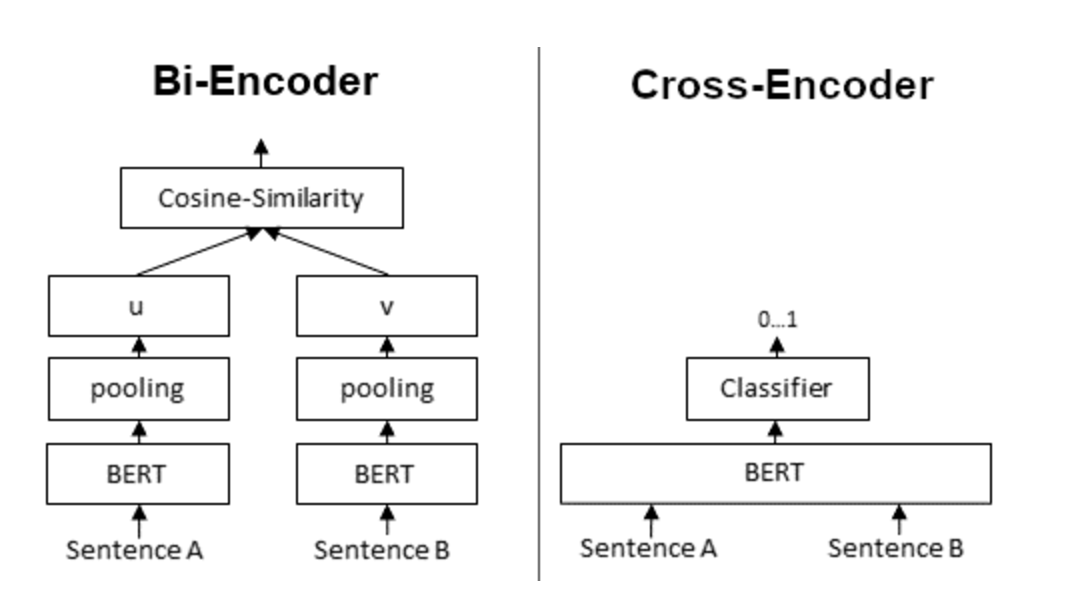

In [89]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

In [90]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [91]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [93]:
# pritn the cross rerank scores
cross_rerank_scores

array([ 3.0535288 ,  4.810115  ,  0.5387672 ,  2.9317627 , -0.9036691 ,
        1.4724654 ,  0.26232392, -1.3536808 ,  2.446185  , -2.6602552 ],
      dtype=float32)

In [94]:
results_df['Reranked_scores'] = cross_rerank_scores

In [95]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.712412,143,3.053529
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.802752,171,4.810115
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",any Accelerated Benefit payment as described i...,0.860201,147,0.538767
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}",Dependent's Life Insurance terminates because ...,0.872965,151,2.931763
4,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",disability that: (1) results from willful self...,0.897980,183,-0.903669
5,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",be the Coverage During Disability benefit in f...,0.908464,146,1.472465
6,"{'Chunk_No.': 5, 'Page_No.': 'Page 50'}",Total Disability began. Failure to give Writte...,0.910233,180,0.262324
7,"{'Chunk_No.': 4, 'Page_No.': 'Page 28'}","terms of the Prior Policy, to have their premi...",0.912592,85,-1.353681
8,"{'Chunk_No.': 5, 'Page_No.': 'Page 50'}","Disability is in force, The Principal will pay...",0.925082,179,2.446185
9,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}","Premium Waiver Period as described in PART IV,...",0.932815,142,-2.660255


In [96]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.712412,143,3.053529
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.802752,171,4.810115
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",any Accelerated Benefit payment as described i...,0.860201,147,0.538767


In [97]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.802752,171,4.810115
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.712412,143,3.053529
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}",Dependent's Life Insurance terminates because ...,0.872965,151,2.931763


In [98]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
1,Payment of benefits will be subject to the Ben...,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}"
0,Member Life Insurance or Coverage During Disab...,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}"
3,Dependent's Life Insurance terminates because ...,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}"


## 8. <font color = red> Retrieval Augmented Generation


Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [101]:
# Set the API key
license_key_path = "/content/drive/My Drive/Colab Notebooks/"
with open(license_key_path + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [102]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [113]:
# Generate the response
response = generate_response(query, top_3_RAG)

In [104]:
# Print the response
print("\n".join(response))

The life insurance coverage for disability provided in the insurance documents is as follows:

| Policy Name                               | Page Number | Disability Coverage         |
|-------------------------------------------|-------------|-----------------------------|
| Member Life Insurance during Disability   | Page 42     | Coverage varies by policy   |

Unfortunately, detailed information on the specific coverage for disability under life insurance policies is not provided in the available documents. For more detailed information on the disability coverage within the mentioned policies, kindly refer to the respective sections on disability coverage within the policies mentioned above.


## 8. <font color = red> Queries

In [144]:
def search(query):

  # Set a threshold for cache search
  threshold = 0.2

  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()

  # try to find from cache
  cache_results = cache_collection.query(
      query_texts=query,
      n_results=1
  )

  # If the distance is greater than the threshold, then return the results from the main collection.
  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the collection against the user query and return the top 10 results
        results = collection.query(
        query_texts=query,
        n_results=10
        )

        # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
        # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
        Keys = []
        Values = []

        size = len(results.items())

        for key, val in results.items():
          if val is None:
            continue
          for i in range(size):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


        cache_collection.add(
            documents= [query],
            ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
            metadatas = dict(zip(Keys, Values))
        )

        #print("Not found in cache. Found in main collection.")

        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)
        return results_df


  # If the distance is, however, less than the threshold, you can return the results from cache

  elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Loop through each inner list and then through the dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        #print("Found in cache!")

        # Create a DataFrame
        return pd.DataFrame({
          'IDs': ids,
          'Documents': documents,
          'Distances': distances,
          'Metadatas': metadatas
        })

In [136]:
def apply_cross_encoder(query, df):
  cross_inputs = [[query, response] for response in df['Documents']]
  cross_rerank_scores = cross_encoder.predict(cross_inputs)
  df['Reranked_scores'] = cross_rerank_scores
  return df

In [137]:
def get_topn(n, df):
  top_3_rerank = df.sort_values(by='Reranked_scores', ascending=False)
  return top_3_rerank[["Documents", "Metadatas"]][:n]

In [145]:
query = 'what is the life insurance coverage for disability'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

The life insurance coverage for disability typically depends on the specific policy terms and conditions outlined in the insurance document. To provide accurate information on coverage details, it is essential to review the policy document. Please refer to the relevant sections within the policy document for specific details on life insurance coverage for disability.

Citation:
- Policy Name: Member Life Insurance or Coverage During Disability
- Page Number: Page 42

Please review the policy document for detailed information on life insurance coverage for disability.


In [147]:
query = 'what is the Proof of ADL Disability or Total Disability'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

The Proof of ADL Disability or Total Disability typically refers to the documentation required to prove the insured individual's inability to perform Activities of Daily Living (ADLs) or work due to a disability.

Based on the available information in the insurance documents, the policy document titled "Member Life Insurance or Coverage During Disability" on Page 42 discusses the termination of Dependent's Life Insurance. This document may not specifically outline the Proof of ADL Disability or Total Disability.

Therefore, the query about the Proof of ADL Disability or Total Disability is not directly addressed in the provided insurance documents.

Citations:
Policy Name: Member Life Insurance or Coverage During Disability
Page Number: Page 42


In [149]:
query = 'what is condition of deatht while not wearing Seat Belt'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

The specific query about the condition of death while not wearing a seatbelt is not directly addressed in the provided insurance documents. However, you can refer to the following related sections in the documents for more information on conditions surrounding death, benefits, and coverage:

1. Payment of benefits subject to the Benefit Precedence provision
2. Member Life Insurance or Coverage During Disability
3. Termination of Dependent's Life Insurance

For detailed information regarding death conditions without wearing a seatbelt, it is recommended to review the entire document or search for specific keywords related to seatbelt non-usage in the respective policy documents.

Citations:
1. Policy Name: Payment of benefits
   Source Page: Page 49

2. Policy Name: Member Life Insurance or Coverage During Disability
   Source Page: Page 42

3. Policy Name: Dependent's Life Insurance termination
   Source Page: Page 44
